# Analisis Sentimen Review Shopee dengan SVM
Model klasifikasi menggunakan Support Vector Machine (SVM) dan TF-IDF untuk memproses review dari Shopee.

In [19]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# --- Preprocessing ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [22]:
# --- Load Data ---
df = pd.read_csv("../scraping-result/Dataset.csv")
df.dropna(subset=["Review", "Rating"], inplace=True)
df["Label"] = df["Rating"].apply(lambda x: 1 if x >= 4 else 0)
df["CleanReview"] = df["Review"].apply(clean_text)

In [23]:
# --- Vectorization ---
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df["CleanReview"])
y = df["Label"]

d:\ulasCheck\venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [24]:

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model = SVC(kernel='linear', class_weight='balanced')
model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [26]:
# --- Evaluation ---
y_pred = model.predict(X_test)
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1059
           1       1.00      1.00      1.00      8697

    accuracy                           1.00      9756
   macro avg       0.99      0.99      0.99      9756
weighted avg       1.00      1.00      1.00      9756



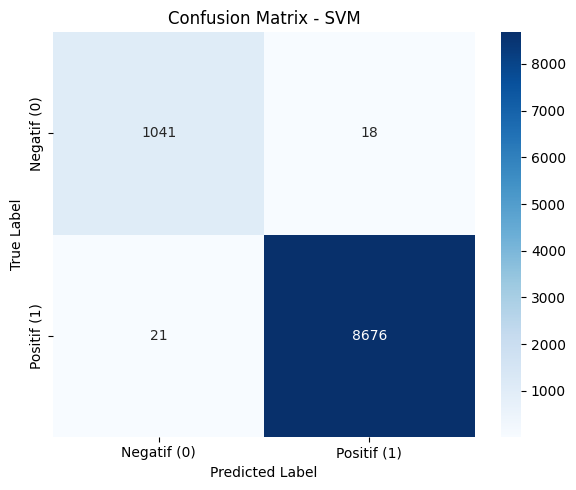

In [27]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
labels = ["Negatif (0)", "Positif (1)"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [28]:
# --- Predict All Data ---
df["PredictedLabel"] = model.predict(X)

In [29]:
# --- Aspect Analysis ---
def analisis_aspek_positif(df, review_col='CleanReview', label_col='PredictedLabel'):
    aspek_keywords = {
        "pengiriman": ["pengiriman", "kirim", "sampai", "cepat", "kurir", "antar", "lambat"],
        "pelayanan": ["pelayanan", "layanan", "respon", "ramah", "cs", "admin", "tanggap"],
        "produk": ["produk", "barang", "kualitas", "bagus", "baik", "ori", "asli"],
        "harga": ["harga", "murah", "diskon", "promo", "terjangkau", "value"],
        "packing": ["packing", "kemasan", "rapi", "aman", "bungkus", "bubble"]
    }
    aspek_counter = defaultdict(int)
    for _, row in df.iterrows():
        if row[label_col] == 1:
            review = row[review_col]
            for aspek, keywords in aspek_keywords.items():
                if any(kw in review for kw in keywords):
                    aspek_counter[aspek] += 1
    return aspek_counter


In [30]:
# --- Store Evaluation ---
total_pos = (df["PredictedLabel"] == 1).sum()
total_neg = (df["PredictedLabel"] == 0).sum()
total_all = total_pos + total_neg
persen_pos = round((total_pos / total_all) * 100, 2)
toko_label = "Direkomendasikan" if persen_pos >= 60 else "Tidak Direkomendasikan"
aspek_result = analisis_aspek_positif(df)
aspek_tertinggi = max(aspek_result, key=aspek_result.get)
jumlah_tertinggi = aspek_result[aspek_tertinggi]
persen_tertinggi = round((jumlah_tertinggi / total_all) * 100, 2)


In [31]:
# --- Summary ---
print("\n=== PENILAIAN TOKO ===")
print(f"- Total Ulasan: {total_all}")
print(f"- Positif: {total_pos} ({persen_pos}%)")
print(f"- Negatif: {total_neg} ({round((total_neg / total_all) * 100, 2)}%)")
print(f"- Label Toko: {toko_label}")
print(f"- Aspek yang menonjol (positif): '{aspek_tertinggi}' sebanyak {jumlah_tertinggi} review ({persen_tertinggi}%).")



=== PENILAIAN TOKO ===
- Total Ulasan: 48776
- Positif: 43462 (89.11%)
- Negatif: 5314 (10.89%)
- Label Toko: Direkomendasikan
- Aspek yang menonjol (positif): 'produk' sebanyak 20913 review (42.88%).


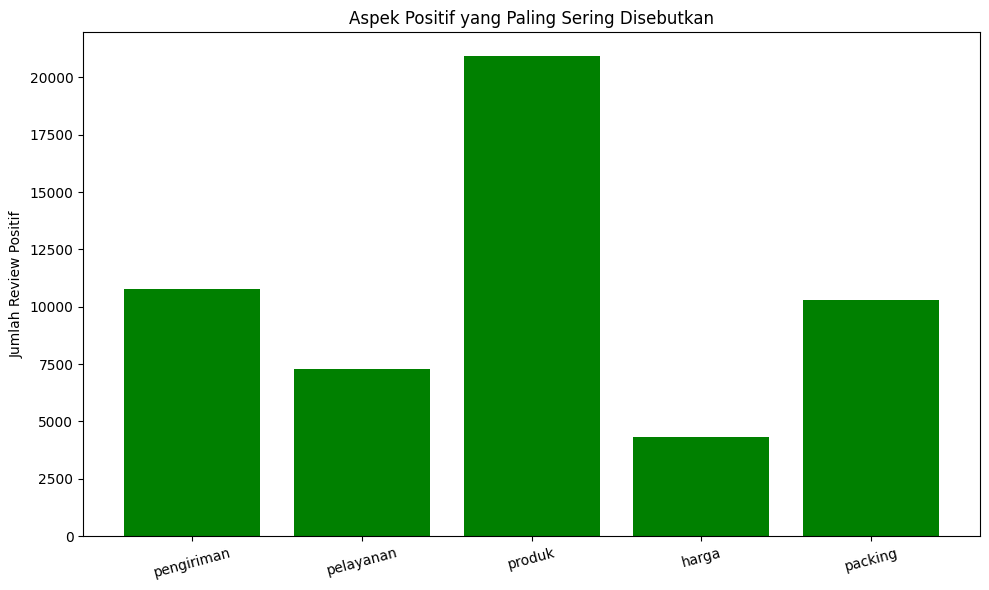

In [32]:
# --- Visualization ---
labels = list(aspek_result.keys())
counts = [aspek_result[k] for k in labels]
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='green')
plt.ylabel("Jumlah Review Positif")
plt.title("Aspek Positif yang Paling Sering Disebutkan")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
